特徴量の重みを正常に反映しているか確認するため、オッズ系統を全て抜いて学習させる。

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
data_dir = "F:/TARGET frontier/TXT33/"
data_name = "train"
tail = "fe7"
train_data = pd.read_csv(data_dir+data_name+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})

In [3]:
pd.set_option('display.max_columns', 100)
train_data.head()

,場所,芝・ダ,距離,クラス名,馬場状態,騎手コード,枠番,性別,年齢,キャリア,斤量,間隔,休み明け〜戦目,種牡馬,父タイプ名,調教師コード,前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走騎手コード,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走PCI3,前走RPCI,前PCI,前好走,前走平均1Fタイム,前走着差タイム,前走単勝オッズ,着差,レースID(旧),複勝オッズ下限,複勝オッズ上限,複勝配当,単勝オッズ,順位,頭数,場所距離芝ダ,場所距離芝ダ.1
0,2,2,1200,2,3,5212,6,2,3,13,56.0,6.0,5.0,572,8,1105,13,2,1400.0,2,2,660.0,2.0,3,54.0,37.2,33.9,59.53,58.2,59.7,0,11.93,0.2,14.6,0.0,0615581112,1.9,2.7,190.0,5.4,1,16,55,37
1,2,2,1200,2,3,5339,6,1,3,10,54.0,3.0,3.0,452,8,1002,1,2,1200.0,7,3,5339.0,7.0,3,54.0,34.5,34.6,48.80,46.9,49.7,0,11.52,0.0,2.2,0.0,0615581111,1.3,1.6,130.0,2.8,2,16,55,12
2,2,2,1200,2,3,5203,3,2,3,9,56.0,5.0,2.0,607,5,1089,3,2,1200.0,2,3,1018.0,8.0,2,56.0,34.5,34.4,50.13,48.0,50.3,0,11.48,0.4,28.6,0.2,0615581106,1.8,2.5,180.0,6.2,3,16,55,170
3,2,2,1200,2,3,1150,4,1,5,17,55.0,2.0,4.0,91,1,1134,2,2,1200.0,2,2,1150.0,6.0,2,53.0,34.1,34.4,48.17,46.3,49.1,0,11.42,0.0,19.1,0.3,0615581108,1.7,2.5,0.0,6.6,4,16,55,101
4,2,2,1200,2,3,1004,8,1,3,15,54.0,2.0,4.0,325,4,1030,2,2,1200.0,2,2,1134.0,2.0,5,53.0,33.6,36.4,48.17,46.3,42.3,1,11.67,1.5,8.6,0.3,0615581116,6.3,9.7,0.0,33.9,5,16,55,101


In [4]:
#test_data
test_data = pd.read_csv(data_dir+"predict"+tail+".csv",encoding="shift-jis",dtype={'レースID(旧)':str})
test_x = test_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当","順位","単勝オッズ","前走単勝オッズ"],axis=1)
test_y = test_data["順位"]

In [5]:
train_x = train_data.drop(["着差","レースID(旧)","複勝オッズ下限","複勝オッズ上限","複勝配当","順位","単勝オッズ","前走単勝オッズ"],axis=1)
train_y = train_data["順位"]

In [6]:
#チューニング済みパラメータ(etaのみ手動)
params = {'colsample_bytree': 0.65, 
          'gamma': 0.013439667332810353, 
          'max_depth': 5, 
          'min_child_weight': 2.663317188920419, 
          'subsample': 0.9, 
          'booster': 'gbtree', 
          'objective': 'reg:squarederror', 
          'eta': 0.01, 
          'alpha': 0.0, 
          'lambda': 1.0, 
          'random_state': 71}

In [7]:
#これがないとエラー履くので注意
train_y.fillna(10,inplace=True) #無ければ10位に
test_y.fillna(10,inplace=True)

In [8]:
scores = []
histories = []
models = []
kf = KFold(n_splits=4,shuffle=False)
for tr_idx,va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y)
    dvalid = xgb.DMatrix(va_x,label=va_y)
    watchlist = [(dtrain,"train"),(dvalid,"eval")]
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=500
    )
    models.append(model)
    histories.append(evals_result)
    va_pred = model.predict(dvalid)
    va_y.fillna(0.5,inplace=True)
    score = mean_squared_error(va_y,va_pred)
    score = np.sqrt(mean_squared_error(va_y,va_pred)) #rmse
    scores.append(score)

print(*scores)
print(np.mean(scores))

[0]	train-rmse:8.54689	eval-rmse:8.62172
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.80136	eval-rmse:3.88268
[1000]	train-rmse:3.72078	eval-rmse:3.8271
[1500]	train-rmse:3.67367	eval-rmse:3.80477
[2000]	train-rmse:3.63828	eval-rmse:3.79268
[2500]	train-rmse:3.6079	eval-rmse:3.78449
[3000]	train-rmse:3.58146	eval-rmse:3.77875
[3500]	train-rmse:3.55678	eval-rmse:3.77464
[4000]	train-rmse:3.53393	eval-rmse:3.77151
[4500]	train-rmse:3.51205	eval-rmse:3.76859
[5000]	train-rmse:3.49083	eval-rmse:3.76637
[5500]	train-rmse:3.47074	eval-rmse:3.765
[6000]	train-rmse:3.45139	eval-rmse:3.76374
[6500]	train-rmse:3.4321	eval-rmse:3.76311
Stopping. Best iteration:
[6867]	train-rmse:3.41816	eval-rmse:3.7624

[0]	train-rmse:8.54418	eval-rmse:8.62942
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 ro

In [9]:
#学習結果のプロット
%matplotlib inline
def plot_loss(evals_result, title):
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()

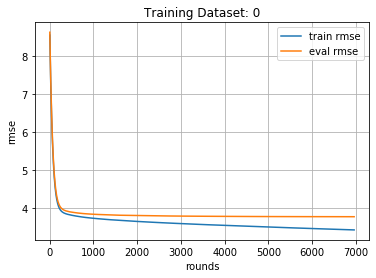

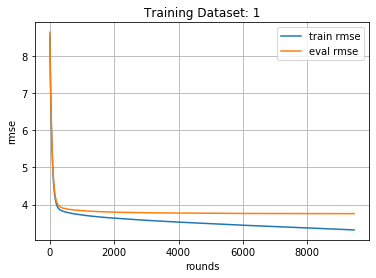

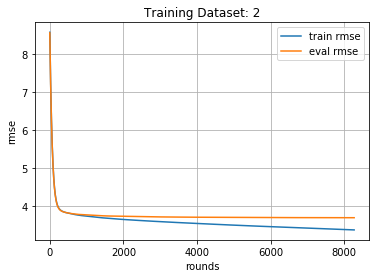

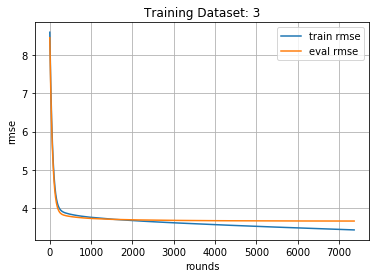

In [10]:
for i in range(4):
    plot_loss(histories[i],f'Training Dataset: {i}')

In [47]:
test_length = len(test_data)
predict = np.array([0.0]*test_length)
dtest = xgb.DMatrix(test_x,label=test_y) #本来は学習に使用していないデータにする
for i in range(4):
    y_pred_proba = models[i].predict(dtest)
    predict += y_pred_proba

predict /= 4

In [48]:
y = pd.DataFrame(predict,columns=["y'"])
output = test_data #ここも書き換えること

output = pd.concat([output,y],axis=1)

output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/neweval5.csv",index=False,encoding="shift-jis")

In [13]:
fscore = model.get_score(importance_type="total_gain")
fscore = sorted([(k,v) for k,v in fscore.items()] ,key=lambda tpl: tpl[1], reverse = True)
print(*fscore[:20])

('頭数', 7906957.4686754355) ('前走着差タイム', 7315011.909421362) ('前好走', 7191000.309355359) ('騎手コード', 3083634.654291067) ('前走上り3F', 1736826.3659108996) ('間隔', 1572795.239923986) ('前距離', 1544416.1217869269) ('クラス名', 1533835.2318965378) ('前クラス名', 1415815.777993747) ('キャリア', 1402685.5006212231) ('調教師コード', 1337176.8482367834) ('前走騎手コード', 1327138.6255068872) ('前走PCI3', 1223552.7753235959) ('種牡馬', 1216271.9416393817) ('前走平均1Fタイム', 1200539.6047308403) ('前PCI', 1109928.426926694) ('前走脚質', 1048322.0866680563) ('前走Ave-3F', 1023922.2654419733) ('距離', 1017147.6570445339) ('前走RPCI', 979432.873133079)


In [14]:
#全体を100[%]とした時の重要度
mother = sum([j for i,j in fscore])
for i,j in fscore[:25]:
    print(i,round((j/mother)*100,1))

頭数 14.9
前走着差タイム 13.8
前好走 13.5
騎手コード 5.8
前走上り3F 3.3
間隔 3.0
前距離 2.9
クラス名 2.9
前クラス名 2.7
キャリア 2.6
調教師コード 2.5
前走騎手コード 2.5
前走PCI3 2.3
種牡馬 2.3
前走平均1Fタイム 2.3
前PCI 2.1
前走脚質 2.0
前走Ave-3F 1.9
距離 1.9
前走RPCI 1.8
場所距離芝ダ 1.4
場所距離芝ダ.1 1.2
年齢 1.2
斤量 1.2
休み明け〜戦目 1.1


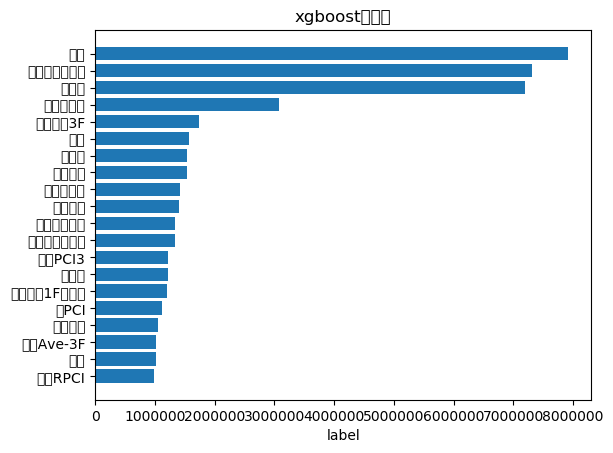

In [15]:
slen = 20
label = []
weight = []
for i,j in fscore[:slen]:
    label.append(i)
    weight.append(j)

plt.rcdefaults() #横棒グラフモード
fig, ax = plt.subplots()
y_pos = np.arange(slen)
ax.barh(y_pos, weight,align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()
ax.set_xlabel('label')
ax.set_title('xgboost特徴量')
plt.show()
    

In [50]:
#save models
import pickle
with open('xgmachina_ver0.0.7.pickle', mode='wb') as fp:
    pickle.dump(models, fp)

In [ ]:
#import models
"""import pickle
with open('xgmachina_ver0.0.6.pickle', mode='rb') as fp:
    models = pickle.load(fp)"""